In [38]:
import os
import statistics
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

In [39]:
def parse_csv(file_name):
    data = {}
    cur_data = None
    with open(file_name) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("ultrasound"):  # New sensor
                sensor_name = line[len("ultrasound"):]
                data[sensor_name] = []
                cur_data = data[sensor_name]
                continue
            line_parts = line.split(",")
            assert len(line_parts) == 2
            if line_parts[0] == "time" and line_parts[1] == "distance":  # correct header
                continue
            try:
                time_stamp = float(line_parts[0])
                distance = float(line_parts[1])
                cur_data.append((time_stamp, distance))
            except ValueError:
                print(f"Could not parse data line '{line}'")
    return data

In [46]:
def plot_data(axis, data, start_at_time_zero=True, label_prefix=None):
    for name in sorted(data.keys()):
        plt_data = np.array(data[name])
        time_offset = plt_data[0, 0] if start_at_time_zero else 0.0
        x_vals = plt_data[:,0] - time_offset
        y_vals = plt_data[:,1]
        y_errs = None
        if len(plt_data[0]) > 2:
            y_errs = plt_data[:,2]
        if y_errs is None:
            axis.plot(x_vals, y_vals, label=name)
        else:
            #axis.errorbar(x_vals, y_vals, y_errs, label=name)
            axis.plot(x_vals, y_vals, label=name)
            y_upper = y_vals + y_errs
            y_lower = y_vals - y_errs
            axis.fill_between(x_vals, y_lower, y_upper, color='wheat')
        if label_prefix is not None:
            axis.set_title(label_prefix)
    axis.legend()

In [47]:
a45_into_files = []
a45_from_files = []
a45_into_from_files = []
for log_file in os.listdir("logs/"):
    if log_file.startswith("hall_angle_45_into_hall_"):
        a45_into_files.append(log_file)
    elif log_file.startswith("hall_angle_45_from_hall_"):
        a45_from_files.append(log_file)
    elif log_file.startswith("hall_angle_45_into_from_hall_"):
        a45_into_from_files.append(log_file)
        
def parse_and_merge(log_file, all_data):
    data = parse_csv("logs/" + log_file)
    run_number = log_file[len("hall_angle_45_into_hall_"):-len(".csv")]
    for name, values in data.items():
        all_data[f"run_{run_number}"] = values
    return all_data

data_empty = parse_csv("logs/hall_angle_45_empty.csv")

data_into = {}
for into_file in a45_into_files:
    parse_and_merge(into_file, data_into)

data_from = {}
for from_file in a45_from_files:
    parse_and_merge(from_file, data_from)

data_into_from = {}
for if_file in a45_into_from_files:
    parse_and_merge(if_file, data_into_from)

    
#data = parse_csv("logs/hall_angle_45_into_from_hall_three_times_1.csv")

Could not parse data line '1600275128.9727437,'
Could not parse data line '1600275153.0327346,'
Could not parse data line '1600275160.2526813,'
Could not parse data line '1600275243.2718127,'
Could not parse data line '1600275258.910566,'
Could not parse data line '1600275339.5224042,'
Could not parse data line '1600274534.633181,'
Could not parse data line '1600274653.740841,'
Could not parse data line '1600274580.3526177,'


In [48]:
def moving_average(data, window_size = 0.5):
    current_window = []
    filtered_data = []
    for d in data:
        current_window.append(d)
        while current_window and d[0] - current_window[0][0] > window_size:
            current_window.pop(0)
        all_data = sum([cd[1] for cd in current_window])
        mavg = all_data/len(current_window)
        filtered_data.append((d[0], mavg))
    return filtered_data

In [131]:
class KalmanFilter(object):
    def __init__(self):
        self.state = np.transpose(np.array([1.35, 0.0]))     # distance, velocity
        self.state_predict = None
        self.cov = np.array([[0.1**2, 0],
                   [0, (0.05/0.1)**2]])
        self.cov_predict = None
    
    def predict(self, delta_t):
        self.state_predict = np.copy(self.state)
        self.state_predict[0] += self.state_predict[1] * delta_t
        F = np.array([[1, delta_t],
                      [0, 1]])
        Q = np.array([[0.005 * delta_t/0.1, 0],
                     [0, 0.005/0.1 * delta_t/0.1]])
        self.cov_predict = np.matmul(np.matmul(F, self.cov), np.transpose(F)) + Q
    
    def correct(self, distance):
        # correct
        H = np.array([[1, 0]])
        y_correct = distance - np.matmul(H, self.state_predict)
        R = np.array([0.2])
        S = np.matmul(np.matmul(H, self.cov_predict), np.transpose(H)) + R
        S_inv = np.array([1.0/S[0]])
        #print(cov_predict.shape)
        #print(H.shape)
        #print(S_inv.shape)
        K = np.matmul(np.matmul(self.cov_predict, np.transpose(H)), S_inv)
        state_correct = np.copy(self.state_predict)
        state_correct += np.matmul(K, y_correct)
        cov_correct = np.matmul((np.identity(2) - np.matmul(K, H)), cov_predict)
        
        state = state_correct
        cov = cov_correct

def kalman_filter(data):
    state = np.transpose(np.array([1.35, 0.0]))     # distance, velocity
    cov = np.array([[0.1**2, 0],
                   [0, (0.05/0.1)**2]])
    filtered_distance = []
    filtered_velocity = []
    filtered_cov = []
    predicted_distance = []
    predicted_velocity = []
    predicted_cov = []
    step = 0
    max_debug_steps = 0
    np.set_printoptions(precision=3, suppress=True)
    for d in data:
        step += 1
        if not filtered_distance:
            delta_t = 0
        else:
            delta_t = d[0] - filtered_distance[-1][0]
        if step < max_debug_steps:
            print(f"\nAt Step {step} - delta_t: {delta_t}")
            print(f"State: \n{state}")
            print(f"Cov: \n{cov}")
        # predict
        state_predict = np.copy(state)
        state_predict[0] += state_predict[1] * delta_t
        F = np.array([[1, delta_t],
                      [0, 1]])
        Q = np.array([[0.005 * delta_t/0.1, 0],
                     [0, 0.005/0.1 * delta_t/0.1]])
        cov_predict = np.matmul(np.matmul(F, cov), np.transpose(F)) + Q
        if step < max_debug_steps:
            print(f"F:\n{F}")
            print(f"Q:\n{Q}")
            print(f"State predict: \n{state_predict}")
            print(f"Cov predict: \n{cov_predict}")
        
        predicted_distance.append((d[0], state_predict[0]))
        predicted_velocity.append((d[0], state_predict[1]))
        predicted_cov.append((d[0], cov_predict))

        # correct
        H = np.array([[1, 0]])
        y_correct = d[1] - np.matmul(H, state_predict)
        R = np.array([0.2])
        S = np.matmul(np.matmul(H, cov_predict), np.transpose(H)) + R
        S_inv = np.array([1.0/S[0]])
        #print(cov_predict.shape)
        #print(H.shape)
        #print(S_inv.shape)
        K = np.matmul(np.matmul(cov_predict, np.transpose(H)), S_inv)
        state_correct = np.copy(state_predict)
        state_correct += np.matmul(K, y_correct)
        cov_correct = np.matmul((np.identity(2) - np.matmul(K, H)), cov_predict)
        
        state = state_correct
        cov = cov_correct
        if step < max_debug_steps:
            print(f"State correct: \n{state}")
            print(f"Cov correct: \n{cov}")
        
        filtered_distance.append((d[0], state[0]))
        filtered_velocity.append((d[0], state[1]))
        filtered_cov.append((d[0], cov))
    return filtered_distance, filtered_velocity, filtered_cov, predicted_distance, predicted_velocity, predicted_cov

In [132]:
def linearize_cov(covs):
    return [(ts, np.linalg.eigvals(cov)) for ts, cov in covs]

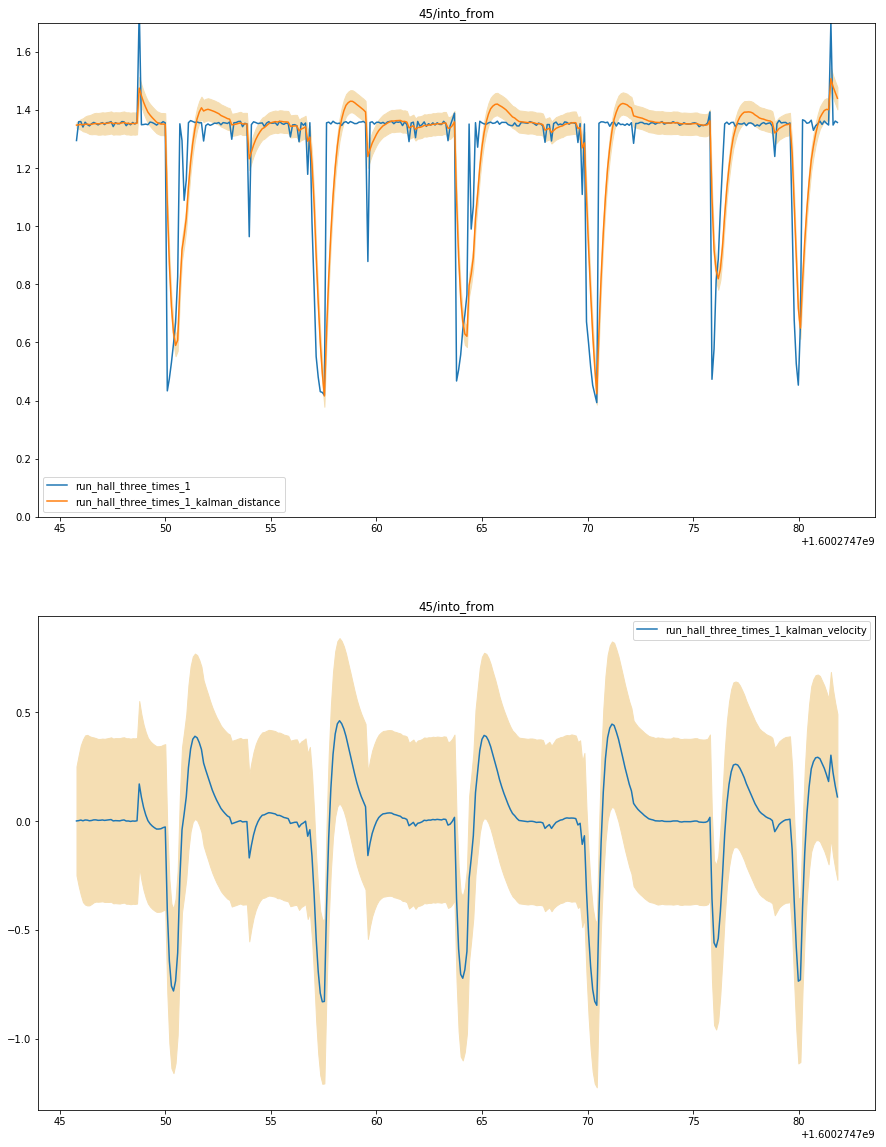

In [136]:
run = "run_1"
run = "run_hall_three_times_1"
data_values = data_into_from[run]
mavg_data = moving_average(data_values)
kalman_dist, kalman_vel, kalman_cov, predict_dist, predict_vel, predict_cov = kalman_filter(data_values)
lin_covs = linearize_cov(kalman_cov)
predict_lin_covs = linearize_cov(predict_cov)
kalman_dist_cov00 = [(ts, c[0, 0]+1) for ts, c in kalman_cov]
kalman_dist_cov = [(ts, cov[0]) for ts, cov in lin_covs]
kalman_vel_cov11 = [(ts, c[1,1]+1) for ts, c in kalman_cov]
kalman_vel_cov = [(ts, cov[1]) for ts, cov in lin_covs]
kalman_dist_errs = [(ts, d, kalman_dist_cov[i][1]) for i, (ts, d) in enumerate(kalman_dist)]
kalman_vel_errs = [(ts, v, kalman_vel_cov[i][1]) for i, (ts, v) in enumerate(kalman_vel)]
predict_dist_cov = [(ts, cov[0]) for ts, cov in predict_lin_covs]
predict_vel_cov = [(ts, cov[1]) for ts, cov in predict_lin_covs]
predict_dist_errs = [(ts, d, predict_dist_cov[i][1]) for i, (ts, d) in enumerate(predict_dist)]
predict_vel_errs = [(ts, v, predict_vel_cov[i][1]) for i, (ts, v) in enumerate(predict_vel)]

current_run = {run : data_into_from[run],
               #run + "_moving_average" : mavg_data,
               run + "_kalman_distance" : kalman_dist_errs,
               #run + "kalman_velocity" : kalman_vel,
              }
current_run_vels = {#run : data_from[run],
               #run + "_moving_average" : mavg_data,
               #run + "_kalman_distance" : kalman_dist,
               run + "_kalman_velocity" : kalman_vel_errs,
              }

predict_run = {#run : data_from[run],
               run + "_predict_distance" : predict_dist_errs,
              }
predict_run_vels = {#run : data_from[run],
               run + "_predict_velocity" : predict_vel_errs,
              }
current_run_covs = {#run : data_from[run],
               #run + "_moving_average" : mavg_data,
               run + "_kalman_dist_cov00" : kalman_dist_cov00,
               run + "_kalman_dist_cov" : kalman_dist_cov,
               run + "_kalman_vel_cov11" : kalman_vel_cov11,
               run + "_kalman_vel_cov" : kalman_vel_cov,
              }


fig, axes = plt.subplots(2,1, figsize=(15,20))
ylim = [0.0, 1.7]
axes[0].set_ylim(ylim)
#axes[2].set_ylim(ylim)
plot_data(axes[0], current_run, start_at_time_zero=False, label_prefix="45/into_from")
plot_data(axes[1], current_run_vels, start_at_time_zero=False, label_prefix="45/into_from")
#plot_data(axes[2], predict_run, start_at_time_zero=False, label_prefix="45/from")
#plot_data(axes[3], predict_run_vels, start_at_time_zero=False, label_prefix="45/from")
#plot_data(axes[4], current_run_covs, start_at_time_zero=False, label_prefix="45/from")